In [1]:
#Importing libraries
import ee
import os
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import datetime


In [2]:
import geemap
import matplotlib.pyplot as plt
import math
import folium

In [4]:
ee.Authenticate()

Enter verification code: 4/1AWgavdfb37FX-VhxsgmF7I6E3Kk-L0C2JuBoWZdbNCOBvZcek1QOqYjQTtM

Successfully saved authorization token.


In [5]:
# triger the GEE API
ee.Initialize()

In [6]:
#Functions to reduce speckle 
# taken from https://github.com/adugnag/gee_s1_ard/

# RefinedLee filter
def RefinedLee(img):
   
    bandNames = img.bandNames().remove('angle')

    def inner(b):

        scene = img.select([b]);
    
        # scene must be linear, i.e. not in dB!
        # Set up 3x3 kernels 
        
        weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
        kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);
  
        mean3 = scene.reduceNeighborhood(ee.Reducer.mean(), kernel3);
        variance3 = scene.reduceNeighborhood(ee.Reducer.variance(), kernel3);
  
        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]]);
  
        sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False);
  
        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel); 
        sample_var = variance3.neighborhoodToBands(sample_kernel);
  
        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs();
        gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs());
        gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs());
        gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs());
  
        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max());
  
        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient);
  
        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask);
  
        # Determine the 8 directions
        directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1);
        directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2));
        directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3));
        directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4));
        
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5));
        directions = directions.addBands(directions.select(1).Not().multiply(6));
        directions = directions.addBands(directions.select(2).Not().multiply(7));
        directions = directions.addBands(directions.select(3).Not().multiply(8));
  
        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask);
  
        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum());  
  
        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean));
  
        #Calculate localNoiseVariance
        sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0]);
  
        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4));
  
        diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);
  
        rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False);
        diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False);
  
        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = scene.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
        dir_var = scene.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1));
  
        dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)));
        dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)));
  
        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
            dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  
        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum());
        dir_var = dir_var.reduce(ee.Reducer.sum());
  
        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  
        b = varX.divide(dir_var)
        result = dir_mean.add(b.multiply(scene.subtract(dir_mean)))
  
        return result.arrayProject([0]).arrayFlatten([['sum']]).float()
    
    result = ee.ImageCollection(bandNames.map(inner)).toBands().rename(bandNames).copyProperties(img)
    
    return img.addBands(result, None, True) 

In [7]:
#function to convert sigma to gamma zero
# taken from DETER SAR github
def toGamma0(img):
    
    vv_gamma0=img.select('VV').subtract(img.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0))
    vh_gamma0=img.select('VH').subtract(img.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0))
    
    return img.addBands(vv_gamma0.rename('VVg0')).addBands(vh_gamma0.rename('VHg0')).copyProperties(img).copyProperties(img,['system:time_start'])

In [8]:
#function to convert db to power scale (recommended by SAR Handbook)
def toPower(img):
    
    base = 10.0
    
    #operation
    
    vv_power = ee.Image(base).pow(img.select('VVg0').divide(base)).rename('VV_pow')
    vh_power = ee.Image(base).pow(img.select('VHg0').divide(base)).rename('VH_pow')
    
    return img.addBands(vv_power).addBands(vh_power).copyProperties(img).copyProperties(img,['system:time_start'])
    

In [9]:
#function to convert power scale to db (recommended by SAR Handbook)

def toDb(img):
    
    base = 10
    
    VV_fdb = ee.Image(base).multiply(img.select('VV_pow').log10()).rename('VV_fdb')
    VH_fdb = ee.Image(base).multiply(img.select('VH_pow').log10()).rename('VH_fdb')
    
    return img.addBands(VV_fdb).addBands(VH_fdb).copyProperties(img).copyProperties(img,['system:time_start'])

In [10]:
#function to create the RFDI band
def rfdi(img):
    num = img.select('VV_pow').subtract(img.select('VH_pow'))
    den = img.select('VV_pow').add(img.select('VH_pow'))
    rfdi = num.divide(den).rename('rfdi')
    return img.addBands(rfdi).copyProperties(img).copyProperties(img,['system:time_start'])

In [11]:
#function to create mosaic with the same date in the AOI extend
def mosaicByDate(imgs):
    imgList = imgs.toList(imgs.size())
    unique_dates = imgList.map(lambda im: ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    
    def mosaic_imlist(d):
        d = ee.Date(d)
        im = imgs.filterDate(d, d.advance(1, "day")).mosaic() 
        return im.set(
        "system:time_start", d.millis(), 
        "system:id", d.format("YYYY-MM-dd"));

    return ee.ImageCollection(unique_dates.map(mosaic_imlist))

In [12]:
# defining period of study

startDate = "2021-01-01"; #no image before
endDate = "2022-09-01"; #exclusive = ie., until 2022-09-30

In [217]:
# Area of interest
#studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/AOI") #loaded from GEE assests
#studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/test_region_forest")
#studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/test_region_river")
studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/subset8")



In [218]:
#Getting the S1 Image Collection

S1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(studyArea).filterDate(ee.Date(startDate), ee.Date(endDate))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) # only descending as ascending images are not available for 2022
          .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])
          .filterMetadata('resolution_meters', 'equals', 10)
          .map(lambda image:image.clip(studyArea.geometry()))
          .map(toGamma0))


countS1 = S1.size()
print('Number of images in the collection: ', str(countS1.getInfo())+'\n')


Number of images in the collection:  71



In [219]:
#separate the original VVg0 and VHg0 for further operations
S1g0=S1.select(['VVg0', 'VHg0'])

# Apply conversion to power before speckle reduction
S1g0_pow=S1g0.map(toPower)

#Apply refinedLee filter for reducing speckle
S1g0_N_filter = S1g0_pow.select(['VV_pow', 'VH_pow']).map(RefinedLee)

# Get the RFDI band and the VV and VH filtered bands in db
S1g0_index = S1g0_N_filter.map(rfdi).map(toDb)

#Combine collections
S1processed = S1g0.combine(S1g0_index)
print("created bands: " + str (S1processed.first().bandNames().getInfo()))


created bands: ['VVg0', 'VHg0', 'VV_pow', 'VH_pow', 'rfdi', 'VV_fdb', 'VH_fdb']


In [220]:
#Select and filter the collections by band

S1_vvf = S1processed.select(['VV_fdb'])

S1_vhf = S1processed.select(['VH_fdb'])

#S1_rfdi = S1processed.select(['rfdi'])

In [221]:
#deleting unnecessary objects
del S1, countS1, S1g0, S1g0_N_filter, S1g0_index, S1processed

In [222]:
#convert the collections to lists and get the dates

collections =[S1_vvf, S1_vhf]
list_c = []
list_dates = []

for c in collections:
   
    ctol = c.toList(c.size())
    unique_dates = ctol.map(lambda im:ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    date_list = unique_dates.getInfo()
    #date_list.sort()

    #variable_name = [k for k, v in locals().items() if v == c][0] 
    #newname = 'list_'+variable_name
    
    list_c.append(ctol)
    list_dates.append(date_list)
    
    
#----------------------------------- 
S1_vv_list = list_c[0] 
S1_vh_list = list_c[1]   


S1_vv_dates = list_dates[0] 
S1_vh_dates = list_dates[1] 


In [223]:
# cleaning memory
del S1_vv_list, S1_vh_list

In [224]:
print("number of scenes: " + str(S1_vhf.size().getInfo()))
print("number of dates: " + str(len(S1_vh_dates)))

number of scenes: 71
number of dates: 71


In [225]:
# mosaicking sneces into the AOI with the same date
vvf_mosaic = mosaicByDate(S1_vhf)
mosaic_size = vvf_mosaic.size().getInfo()
print('size of Image Stack after mosaicking: ' ,mosaic_size)

size of Image Stack after mosaicking:  71


In [226]:
del list_dates, list_c,collections, S1_vv_dates

In [227]:
#Export images to collection folder

outdir = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\log_ratio_vh_sub8'

crs = "EPSG:4326"
geemap.ee_export_image_collection(vvf_mosaic, scale=30,out_dir=outdir, region=studyArea.geometry(),crs=crs)

Total number of images: 71

Exporting 1/71: 0.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\0.tif


Exporting 2/71: 1.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\1.tif


Exporting 3/71: 2.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\2.tif


Exporting 4/71: 3.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\3.tif


Exporting 5/71: 4.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\4.tif


Exporting 6/71: 5.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\5.tif


Exporting 7/71: 6.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\

Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\25.tif


Exporting 27/71: 26.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\26.tif


Exporting 28/71: 27.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\27.tif


Exporting 29/71: 28.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\28.tif


Exporting 30/71: 29.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\29.tif


Exporting 31/71: 30.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\30.tif


Exporting 32/71: 31.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\31.tif


Exporting 33/71: 32.tif
Generating URL ...
Please wait ...

Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\51.tif


Exporting 53/71: 52.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\52.tif


Exporting 54/71: 53.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\53.tif


Exporting 55/71: 54.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\54.tif


Exporting 56/71: 55.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\55.tif


Exporting 57/71: 56.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\56.tif


Exporting 58/71: 57.tif
Generating URL ...
Please wait ...
Data downloaded to D:\NOVAIMS\TESIS_PROJECT\Data\Outputs\log_ratio_vh_sub8\57.tif


Exporting 59/71: 58.tif
Generating URL ...

In [228]:
# list all downloaded images
import glob
outdir = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\log_ratio_vh_sub8'
#vv_tifs = os.listdir(outdir)
#files = list(filter(os.path.isfile, glob.glob(outdir + "*.tif")))
files = glob.glob(outdir+"/*.tif")  
#sort images by download time
files.sort(key=lambda x: os.path.getctime(x))

In [229]:
list_da=[]
for file, date in zip(files, S1_vh_dates):
    da = xr.open_rasterio(file,masked=True)
    dt = datetime.datetime.strptime(date,"%Y-%m-%d")
    dt = pd.to_datetime(dt)
    da = da.assign_coords(time = dt)
    da = da.expand_dims(dim="time")
    list_da.append(da)

C:\Users\usuario\AppData\Local\Temp\ipykernel_4620\1877886222.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  da = xr.open_rasterio(file,masked=True)


In [230]:
#stack data arrays in list
ts = xr.combine_by_coords(list_da)

In [231]:
ts

<xarray.DataArray (time: 71, band: 1, y: 619, x: 601)>
array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -11.39258863, ..., -12.84962439,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -11.24349351, ...,  -9.72295578,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -11.94939853, ..., -14.63564264,
...
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -12.02696674, ..., -12.48084446,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -12.43060584, ..., -11.19043859,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56
  * time     (time) datetime64[ns] 2021-01-11 2021-01-17 ... 2022-08-22
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.72429993289263...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### Specif steps for log-ratio apprach 

In [232]:
#demonstrate that the region does not have seasonality 

# get backscatter mean for each date
#dsmean = ts_vv.mean(dim='time', keep_attrs=True) #replace the time series Xarraydataset for other bands
meanxdate = ts.mean(dim=['y', 'x'], keep_attrs=True) #replace the time series Xarraydataset for other bands

meanxdate

<xarray.DataArray (time: 71, band: 1)>
array([[-11.73139697],
       [-12.02293285],
       [-11.88471492],
       [-11.78508997],
       [-11.73831926],
       [-11.90804951],
       [-12.10251753],
       [-11.88390316],
       [-11.80576755],
       [-11.81153626],
       [-12.06154071],
       [-11.7886927 ],
       [-12.20101147],
       [-11.99457859],
       [-12.14560556],
       [-11.72634523],
       [-12.30314644],
       [-11.65493937],
       [-12.03898998],
       [-12.072002  ],
...
       [-11.89385752],
       [-11.71255492],
       [-11.9521589 ],
       [-12.15033356],
       [-11.86622849],
       [-12.08677667],
       [-11.85306744],
       [-11.92553918],
       [-11.77827477],
       [-12.45403161],
       [-11.7607235 ],
       [-11.79190792],
       [-11.98930932],
       [-11.80366086],
       [-12.05539715],
       [-11.84992208],
       [-11.91779061],
       [-12.02143493],
       [-11.90616255],
       [-12.00913801]])
Coordinates:
  * band     (band) int32 1
  * time     (time) datetime64[ns] 2021-01-11 2021-01-17 ... 2022-08-22
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.72429993289263...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [233]:
#slicing the time series for testing possible workflow with log ratio
# first period
ts_ref = ts.sel(time=slice('2021-01-01', '2021-12-30'))
ts_ref

<xarray.DataArray (time: 51, band: 1, y: 619, x: 601)>
array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -11.39258863, ..., -12.84962439,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -11.24349351, ...,  -9.72295578,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -11.94939853, ..., -14.63564264,
...
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -12.06423721, ..., -13.93548176,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -12.41271275, ...,  -9.6459163 ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56
  * time     (time) datetime64[ns] 2021-01-11 2021-01-17 ... 2021-12-19
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.72429993289263...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [234]:
ts_mon = ts.sel(time=slice('2022-01-01', '2022-09-01'))
ts_mon

<xarray.DataArray (time: 20, band: 1, y: 619, x: 601)>
array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -12.99152081, ..., -14.60402697,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -11.034969  , ..., -11.81882232,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -11.59428749, ..., -11.52978091,
...
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]],


       [[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        , -12.02696674, ..., -12.48084446,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        , -12.43060584, ..., -11.19043859,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56
  * time     (time) datetime64[ns] 2022-01-06 2022-01-18 ... 2022-08-22
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.72429993289263...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (nan,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [235]:
#mean value for each pixel 
mean_ref = ts_ref.mean(dim='time', keep_attrs=True)

In [236]:
mean_mon = ts_mon.mean(dim='time', keep_attrs=True)

In [237]:
#transforming the values to power domain

refpwr = np.power(10, (mean_ref/10))

refpwr

<xarray.DataArray (band: 1, y: 619, x: 601)>
array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 0.06306765, ..., 0.05110085,
         1.        , 1.        ],
        ...,
        [1.        , 1.        , 0.07023377, ..., 0.0892255 ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56

In [238]:
monpwr = np.power(10, (mean_mon/10))

monpwr

<xarray.DataArray (band: 1, y: 619, x: 601)>
array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 0.06039562, ..., 0.05007879,
         1.        , 1.        ],
        ...,
        [1.        , 1.        , 0.0686669 , ..., 0.09020863,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56

In [239]:
#performing the log operation and using the Quotient Rule loga(m/n) = logam – logan

ch = np.log10((monpwr/refpwr))
ch

<xarray.DataArray (band: 1, y: 619, x: 601)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.01880119, ..., -0.00877426,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.00979855, ...,  0.0047591 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56

In [206]:
#ch.to_array()

In [240]:
ch.max()

<xarray.DataArray ()>
array(0.7089893)

In [241]:
ch.min()

<xarray.DataArray ()>
array(-0.69271083)

In [242]:
#da_ch = ch.to_array()

In [243]:
aver = ch.mean()
aver.item(0)

-0.0030773391901485697

In [244]:
dev = ch.std()
dev.item(0)

0.032067637538280076

In [245]:
# masking change

val = aver - 3*dev

defo = ch.where(ch<= val,np.nan)
defo


<xarray.DataArray (band: 1, y: 619, x: 601)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.127 5.127 5.127 5.126 ... 4.962 4.961 4.961 4.961
  * x        (x) float64 -76.72 -76.72 -76.72 -76.72 ... -76.56 -76.56 -76.56

In [246]:
print ('min: ' + str(defo.min()) + '/n' + 'max: ' + str(defo.max()))

min: <xarray.DataArray ()>
array(-0.69271083)/nmax: <xarray.DataArray ()>
array(-0.09928509)


In [247]:
defo.name = 'noforest'


pathDefo = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\log_ratio_vh_sub8\\Deforestation_sub8.tif'   # path to your folder

tifDefo = defo.rio.write_crs(crs)
tifDefo.rio.to_raster(pathDefo,compress='LZMA')



(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
        4.0000e+00, 1.0000e+01, 2.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 6.0000e+00, 5.0000e+00, 6.0000e+00, 8.0000e+00,
        1.3000e+01, 8.0000e+00, 1.8000e+01, 2.1000e+01, 2.2000e+01,
        2.6000e+01, 3.3000e+01, 4.4000e+01, 3.0000e+01, 3.3000e+01,
        6.1000e+01, 5.4000e+01, 6.9000e+01, 7.1000e+01, 1.1100e+02,
        1.0400e+02, 1.1900e+02, 1.6700e+02, 2.0700e+02, 2.7800e+02,
        4.0500e+02, 5.8300e+02, 1.1180e+03, 2.5310e+03, 7.1480e+03,
        2.0604e+04, 4.8060e+04, 7.9703e+04, 9.3127e+04, 6.4919e+04,
        3.2568e+04, 1.2428e+04, 4.2170e+03, 1.5610e+03, 5.7600e+02,
        2.9300e+02, 1.5700e+02, 9.7000e+01, 6.40

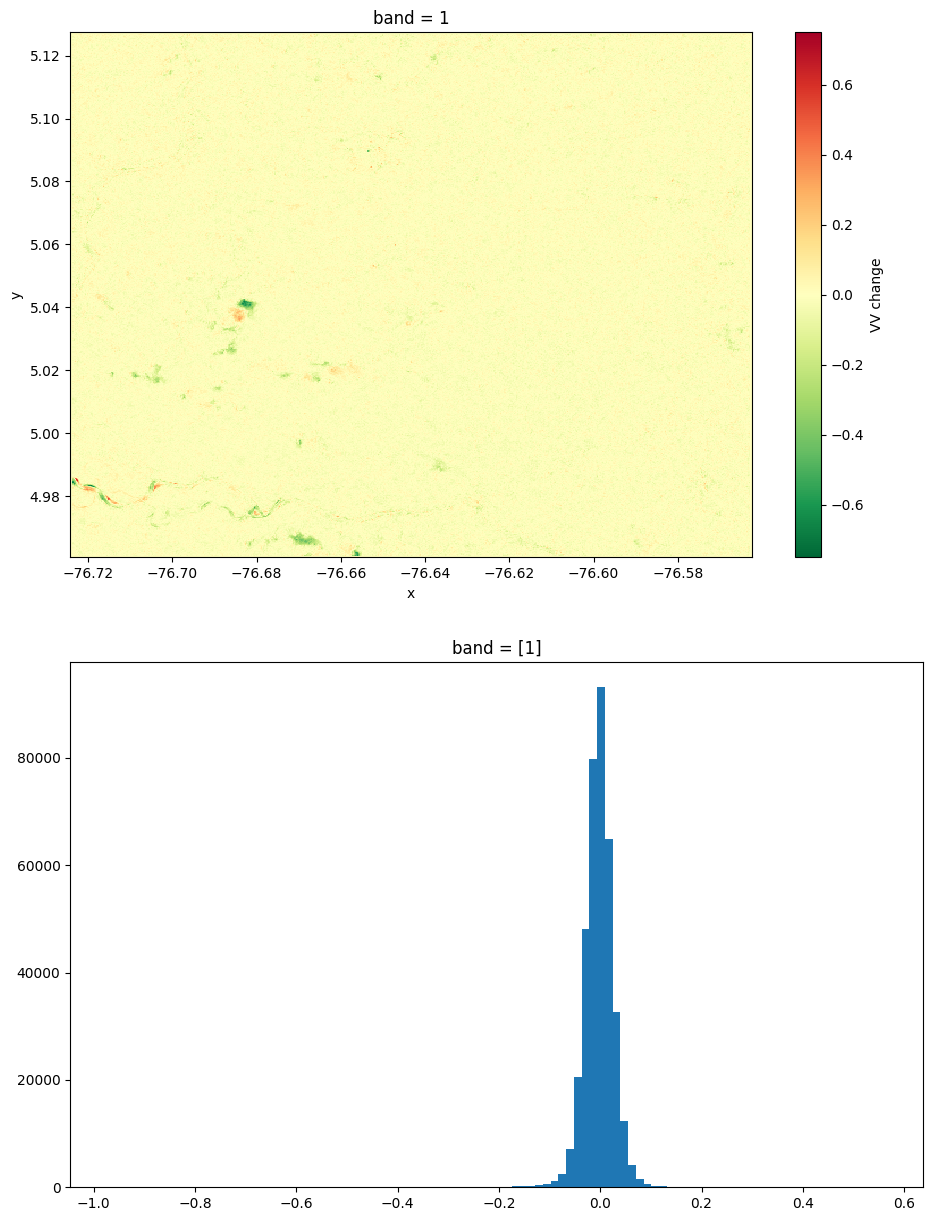

In [248]:
#t2.plot()

fig, axs = plt.subplots(2,1, figsize=(11, 15))

axs

#ax.plot = tsvis.plot(cmap="Greys", vmin = 0, vmax = 0.3, cbar_kwargs={'label': 'VH Backscatter'})
ch.plot(ax = axs[0],cmap="RdYlGn_r", vmin = -0.75, vmax = 0.75, cbar_kwargs={'label': 'VV change'})
#ax.hist(t2.flatten(),bins=100,range=(-1.6,0.7)) 
ch.plot.hist(ax=axs[1], bins = 100, range = (-0.97, 0.56))

In [148]:
da.min()

<xarray.DataArray ()>
array(-21.93783131)

In [48]:
S1_vh_dates

['2021-01-11',
 '2021-01-23',
 '2021-02-04',
 '2021-02-16',
 '2021-02-28',
 '2021-03-12',
 '2021-03-24',
 '2021-04-05',
 '2021-04-17',
 '2021-04-29',
 '2021-07-22',
 '2021-08-15',
 '2021-08-27',
 '2021-09-08',
 '2021-09-20',
 '2021-10-02',
 '2021-10-14',
 '2021-10-26',
 '2021-11-07',
 '2021-11-19',
 '2021-12-01',
 '2021-12-13',
 '2022-01-06',
 '2022-01-18',
 '2022-01-30',
 '2022-02-11',
 '2022-02-23',
 '2022-03-07',
 '2022-03-19',
 '2022-03-31',
 '2022-04-12',
 '2022-04-24',
 '2022-05-06',
 '2022-05-18',
 '2022-05-30',
 '2022-06-11',
 '2022-06-23',
 '2022-07-05',
 '2022-07-17',
 '2022-07-29',
 '2022-08-10',
 '2022-08-22',
 '2021-01-17',
 '2021-01-29',
 '2021-02-10',
 '2021-02-22',
 '2021-03-06',
 '2021-03-18',
 '2021-03-30',
 '2021-04-11',
 '2021-04-23',
 '2021-05-05',
 '2021-05-17',
 '2021-05-29',
 '2021-06-10',
 '2021-06-22',
 '2021-07-04',
 '2021-07-16',
 '2021-07-28',
 '2021-08-09',
 '2021-08-21',
 '2021-09-02',
 '2021-09-14',
 '2021-09-26',
 '2021-10-08',
 '2021-10-20',
 '2021-11-